In [1]:
import os
from pathlib import Path
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from typing import Optional
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix
)

from tqdm.auto import tqdm
from torch.amp import GradScaler, autocast

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# -------------------------------------------------------------
# 1. Dataset
# -------------------------------------------------------------

class TumorDataset(Dataset):
    def __init__(self, metadata, jpeg_dir, masks_dir=None, img_size=(256, 256)):
        self.metadata  = metadata.reset_index(drop=True)
        self.jpeg_dir  = Path(jpeg_dir)
        self.masks_dir = Path(masks_dir) if masks_dir else None
        self.img_size  = img_size

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]

        # ---------- load image (single-channel) -----------------------------
        img_path = Path(row["image_path"])
        img = Image.open(img_path).convert("L").resize(self.img_size)
        img_np = (np.array(img, dtype=np.float32) / 255.0)        # H×W, float32
        img_t  = torch.from_numpy(img_np).unsqueeze(0)            # 1×H×W

        # ---------- load mask or auto-segment ------------------------------
        mask_path = row.get("mask_path")
        if mask_path and Path(mask_path).exists():
            mask = Image.open(mask_path).convert("L").resize(self.img_size)
            mask_np = (np.array(mask) > 0).astype(np.float32)
        else:
            mask_np = self._segment_tumor(np.array(img)).astype(np.float32)

        mask_t = torch.from_numpy(mask_np).unsqueeze(0)           # 1×H×W

        return img_t, mask_t

    # ---------------------------------------------------------------------
    def _segment_tumor(self, image):
        """
        Simple Otsu threshold fallback when no ground-truth mask exists.
        Input can be RGB or grayscale numpy array.
        Returns boolean array (True = foreground).
        """
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(
            blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        return binary > 0

In [4]:
# -------------------------------------------------------------
# 2. U-Net++ model
# -------------------------------------------------------------
class _ConvBlock(nn.Module):
   def __init__(self, in_c, mid_c, out_c):
       super().__init__()
       self.net = nn.Sequential(
           nn.Conv2d(in_c, mid_c, 3, padding=1, bias=True),
           nn.BatchNorm2d(mid_c),
           nn.ReLU(inplace=True),
           nn.Conv2d(mid_c, out_c, 3, padding=1, bias=True),
           nn.BatchNorm2d(out_c),
           nn.ReLU(inplace=True),
       )

   def forward(self, x):
       return self.net(x)


class UNetPlusPlus(nn.Module):

   def __init__(
       self,
       in_ch=1,
       out_ch=1,
       n1=64,
       height=256,
       width=256,
       deep_supervision: bool = False,
   ):
       super().__init__()
       f = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
       self.deep_supervision = deep_supervision
       self.pool = nn.MaxPool2d(2, 2)
       # dynamic bilinear up-samplers so model works for any H×W
       self.up = nn.ModuleList(
           [
               nn.Upsample(size=(height // 2**i, width // 2**i),
                           mode="bilinear", align_corners=True)
               for i in range(0, 4)
           ]
       )
       # encoder
       self.conv00 = _ConvBlock(in_ch, f[0], f[0])
       self.conv10 = _ConvBlock(f[0], f[1], f[1])
       self.conv20 = _ConvBlock(f[1], f[2], f[2])
       self.conv30 = _ConvBlock(f[2], f[3], f[3])
       self.conv40 = _ConvBlock(f[3], f[4], f[4])
       # decoder – nested blocks
       self.conv01 = _ConvBlock(f[0] + f[1], f[0], f[0])
       self.conv11 = _ConvBlock(f[1] + f[2], f[1], f[1])
       self.conv21 = _ConvBlock(f[2] + f[3], f[2], f[2])
       self.conv31 = _ConvBlock(f[3] + f[4], f[3], f[3])

       self.conv02 = _ConvBlock(f[0] * 2 + f[1], f[0], f[0])
       self.conv12 = _ConvBlock(f[1] * 2 + f[2], f[1], f[1])
       self.conv22 = _ConvBlock(f[2] * 2 + f[3], f[2], f[2])

       self.conv03 = _ConvBlock(f[0] * 3 + f[1], f[0], f[0])
       self.conv13 = _ConvBlock(f[1] * 3 + f[2], f[1], f[1])

       self.conv04 = _ConvBlock(f[0] * 4 + f[1], f[0], f[0])

       self.out_layers = nn.ModuleList(
           [nn.Conv2d(f[0], out_ch, 1) for _ in range(4)]
       )

   def forward(self, x):

       x00 = self.conv00(x)
       x10 = self.conv10(self.pool(x00))
       x20 = self.conv20(self.pool(x10))
       x30 = self.conv30(self.pool(x20))
       x40 = self.conv40(self.pool(x30))

       x01 = self.conv01(torch.cat([x00, self.up[0](x10)], 1))
       x11 = self.conv11(torch.cat([x10, self.up[1](x20)], 1))
       x21 = self.conv21(torch.cat([x20, self.up[2](x30)], 1))
       x31 = self.conv31(torch.cat([x30, self.up[3](x40)], 1))

       x02 = self.conv02(torch.cat([x00, x01, self.up[0](x11)], 1))
       x12 = self.conv12(torch.cat([x10, x11, self.up[1](x21)], 1))
       x22 = self.conv22(torch.cat([x20, x21, self.up[2](x31)], 1))

       x03 = self.conv03(torch.cat([x00, x01, x02, self.up[0](x12)], 1))
       x13 = self.conv13(torch.cat([x10, x11, x12, self.up[1](x22)], 1))

       x04 = self.conv04(torch.cat([x00, x01, x02, x03, self.up[0](x13)], 1))

       outputs = [
           self.out_layers[0](x01),
           self.out_layers[1](x02),
           self.out_layers[2](x03),
           self.out_layers[3](x04),
       ]

       if self.deep_supervision:
           return outputs
       else:
           return outputs[-1]

In [5]:
# -------------------------------------------------------------
# 3. Trainer
# -------------------------------------------------------------
class TumorTrainer:
    def __init__(self, base_dir="data"):
        self.base_dir  = Path(base_dir)
        self.csv_dir   = self.base_dir / "csv"
        self.jpeg_dir  = self.base_dir / "jpeg"
        self.masks_dir = self.base_dir / "masks"
        self.device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _load_and_prepare_metadata(self, csv_file):
        """Загрузка и подготовка метаданных"""
        print(f"Загрузка метаданных из {csv_file}...")
        try:
            df = pd.read_csv(self.csv_dir / csv_file)

            # Поиск путей к изображениям
            df['image_path'] = df['image file path'].apply(
                lambda x: self._find_image_path(x))

            # Поиск путей к маскам (если есть)
            if 'cropped image file path' in df.columns:
                df['mask_path'] = df['cropped image file path'].apply(
                    lambda x: self._find_mask_path(x))

            df['has_image'] = df['image_path'].apply(
                lambda x: x is not None and os.path.exists(x))

            valid_df = df[df['has_image']].copy()
            print(f"Найдено {len(valid_df)} валидных примеров")
            return valid_df

        except Exception as e:
            print(f"Ошибка загрузки: {str(e)}")
            return pd.DataFrame()

    def _find_image_path(self, csv_path):
        """Находит путь к изображению по данным из CSV"""
        try:
            parts = csv_path.split('/')
            if len(parts) < 2:
                return None

            uid = parts[-2]  # Получаем UID из пути
            jpeg_file = next((self.jpeg_dir / uid).glob('*.jp*'), None)
            return str(jpeg_file) if jpeg_file else None
        except:
            return None

    def _find_mask_path(self, csv_path):
        """Находит путь к маске по данным из CSV"""
        try:
            if not self.masks_dir.exists():
                return None

            parts = csv_path.split('/')
            if len(parts) < 2:
                return None

            uid = parts[-2]
            mask_file = next((self.masks_dir / uid).glob('*.png'), None)
            return str(mask_file) if mask_file else None
        except:
            return None

    def load_datasets(self):
        """Загрузка тренировочного и тестового наборов"""
        train_df = self._load_and_prepare_metadata("mass_case_description_train_set.csv")
        test_df = self._load_and_prepare_metadata("mass_case_description_test_set.csv")

        if len(train_df) == 0 or len(test_df) == 0:
            raise ValueError("Недостаточно данных для обучения")

        train_dataset = TumorDataset(train_df, self.jpeg_dir, self.masks_dir)
        test_dataset = TumorDataset(test_df, self.jpeg_dir, self.masks_dir)

        return train_dataset, test_dataset

   # ------------ training with early stopping ----------------
    def train(self, epochs=25, batch_size=8, lr=1e-4, patience=5):
    # 1) making sure cudnn autotuner is on
      torch.backends.cudnn.benchmark = True

    # ◆── Load datasets ──◆
      train_ds, val_ds = self.load_datasets()

    # ◆── DataLoaders ──◆
      train_loader = DataLoader(
          train_ds,
          batch_size=batch_size,
          shuffle=True,
          num_workers=8,
          pin_memory=True
      )
      val_loader = DataLoader(
          val_ds,
          batch_size=batch_size,
          num_workers=4,
          pin_memory=True
      )

    # ◆── model on the right device ──◆
      img_h, img_w = train_ds.img_size
      model = UNetPlusPlus(in_ch=1, out_ch=1, n1=32,
                           height=img_h, width=img_w).to(self.device)

      criterion = nn.BCEWithLogitsLoss()
      optimizer = optim.Adam(model.parameters(), lr=lr)
      scaler = torch.cuda.amp.GradScaler()

      best_val, bad_epochs = float('inf'), 0
      history = {'train_loss': [], 'val_loss': []}

      for epoch in range(1, epochs+1):
          # — Training loop —
          model.train()
          running = 0.0
          for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
              imgs, masks = imgs.to(self.device), masks.to(self.device)
              optimizer.zero_grad()

              with torch.cuda.amp.autocast():
                  outputs = model(imgs)
                  loss = criterion(outputs, masks)

              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

              running += loss.item()

          train_loss = running / len(train_loader)
          history['train_loss'].append(train_loss)

        # — Validation loop —
          model.eval()
          running = 0.0
          with torch.no_grad():
              for imgs, masks in val_loader:
                  imgs, masks = imgs.to(self.device), masks.to(self.device)
                  with torch.cuda.amp.autocast():
                      outputs = model(imgs)
                      running += criterion(outputs, masks).item()
          val_loss = running / len(val_loader)
          history['val_loss'].append(val_loss)

          print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        # — Early stopping —
          if val_loss < best_val:
              best_val, bad_epochs = val_loss, 0
              ckpt_path = self.base_dir / "best_model.pth"
              torch.save(model.state_dict(), str(ckpt_path))
              print(f"  ✓ New best model saved to {ckpt_path}")
          else:
              bad_epochs += 1
              print(f"  ✗ No improvement ({bad_epochs}/{patience})")
              if bad_epochs >= patience:
                  print("Early stopping triggered.")
                  break

    # — Plotting losses —
      plt.plot(history['train_loss'], label='train')
      plt.plot(history['val_loss'],   label='val')
      plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

      return model

Загрузка метаданных из mass_case_description_train_set.csv...
Найдено 1318 валидных примеров
Загрузка метаданных из mass_case_description_test_set.csv...
Найдено 378 валидных примеров


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-5-1ccaa36c10bb>:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is

Epoch 1/30:   0%|          | 0/165 [00:00<?, ?it/s]

<ipython-input-5-1ccaa36c10bb>:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-1ccaa36c10bb>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train_loss=0.2716 | val_loss=0.2197
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 2/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 02 | train_loss=0.1985 | val_loss=0.1750
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 3/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.1596 | val_loss=0.1412
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 4/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.1313 | val_loss=0.1089
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 5/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>^
^Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
               ^^ ^^^^^^^^^^^^^^^^^^^^^^^

Epoch 05 | train_loss=0.1079 | val_loss=0.0953
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 6/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 06 | train_loss=0.0921 | val_loss=0.0900
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 7/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.0799 | val_loss=0.0703
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 8/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.0693 | val_loss=0.0637
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 9/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>    Traceback (most recent call last):


self._shutdown_workers()self._shutdown_workers()

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_worker

Epoch 09 | train_loss=0.0629 | val_loss=0.0555
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 10/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.0559 | val_loss=0.0514
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 11/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11 | train_loss=0.0492 | val_loss=0.0456
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 12/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():
^^ ^^

Epoch 12 | train_loss=0.0432 | val_loss=0.0427
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 13/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13 | train_loss=0.0427 | val_loss=0.0389
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 14/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14 | train_loss=0.0391 | val_loss=0.0352
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 15/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.0361 | val_loss=0.0339
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>   
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^
^ ^ ^^^ ^^^ ^^ 
 Exception ignored in:   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>    ^
assert self._pare

Epoch 16/30:   0%|          | 0/165 [00:11<?, ?it/s]

 ^^^^^^^^ ^^^^ ^ ^ ^^^^^ ^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^
^^AssertionError^    
assert self._parent_pid == os.getpid(), 'can only test a child process': ^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^can only test a child process    
^
assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^^^ ^ ^Exception ignored in: ^^
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>^^ ^
^ ^
Traceback (most recent call last):

 ^   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
AssertionError^     :  ^self._shutdown_workers()can only test a child process ^^ 

AssertionError        : ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^can only test a child process     ^^^if w.is_alive(): 
Exception ignored in: ^ <function _MultiProcessingDataLoa

Epoch 16 | train_loss=0.0342 | val_loss=0.0312
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 17/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17 | train_loss=0.0326 | val_loss=0.0348
  ✗ No improvement (1/5)


Epoch 18/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18 | train_loss=0.0298 | val_loss=0.0278
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 19/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^^self._shutdown_workers()^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():  
               ^ ^^^^^^^^^^^^^^^^^^^^^^
^

Epoch 19 | train_loss=0.0291 | val_loss=0.0337
  ✗ No improvement (1/5)


Epoch 20/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       Exception ignored in: if w.is_alive(): <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
  
  ^ Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Epoch 20 | train_loss=0.0289 | val_loss=0.0324
  ✗ No improvement (2/5)


Epoch 21/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 21 | train_loss=0.0271 | val_loss=0.0262
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 22/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 22 | train_loss=0.0252 | val_loss=0.0258
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 23/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 23 | train_loss=0.0257 | val_loss=0.0254
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>

Epoch 24/30:   0%|          | 0/165 [00:00<?, ?it/s]


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^
 ^ ^^  ^ ^ ^ ^^^^
^AssertionError^: ^can only test a child process^
^^^^^^
  File "/usr/lib/python

Epoch 24 | train_loss=0.0258 | val_loss=0.0245
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 25/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 25 | train_loss=0.0222 | val_loss=0.0243
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 26/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 26 | train_loss=0.0219 | val_loss=0.0293
  ✗ No improvement (1/5)


Epoch 27/30:   0%|          | 0/165 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a4fc00445e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 27 | train_loss=0.0218 | val_loss=0.0243
  ✗ No improvement (2/5)


Epoch 28/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 28 | train_loss=0.0213 | val_loss=0.0220
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 29/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 29 | train_loss=0.0218 | val_loss=0.0214
  ✓ New best model saved to drive/MyDrive/data/best_model.pth


Epoch 30/30:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 30 | train_loss=0.0212 | val_loss=0.0246
  ✗ No improvement (1/5)


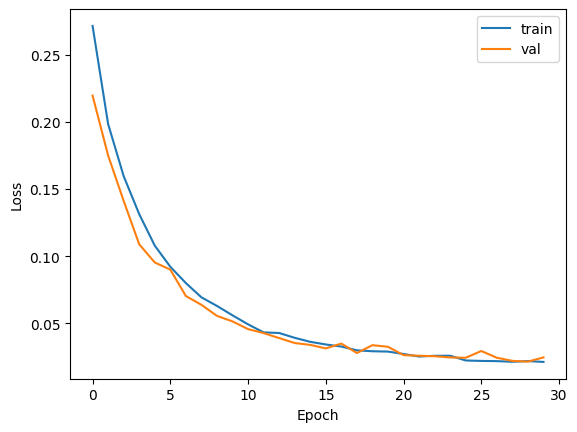

Done. Final checkpoint is at drive/MyDrive/data/best_model.pth


In [6]:
# -------------------------------------------------------------
# 4. script entry-point
# -------------------------------------------------------------
if __name__ == "__main__":
    trainer = TumorTrainer(base_dir="drive/MyDrive/data")
    model   = trainer.train(epochs=30, batch_size=8, lr=1e-4, patience=5)
#    print("Done. Best weights saved to best_model.pth")
    print("Done. Final checkpoint is at", trainer.base_dir / "best_model.pth")

In [7]:
def evaluate_segmentation(model, dataset, device, batch_size=8):
   """
   Computing Dice, IoU, Accuracy, Sensitivity, Specificity, ROC & AUC
   on a segmentation dataset.
   """
   loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True)
   model = model.to(device).eval()

   # accumulators
   all_probs = []
   all_preds = []
   all_gts   = []

   # TP, TN, FP, FN counters
   TP = TN = FP = FN = 0

   with torch.no_grad():
       for imgs, masks in loader:
           imgs  = imgs.to(device)
           masks = masks.to(device)

           logits = model(imgs)                          # raw output
           probs  = torch.sigmoid(logits).cpu().numpy()   # N×1×H×W
           preds  = (probs >= 0.5).astype(np.uint8)

           gt_np  = masks.cpu().numpy().astype(np.uint8)

           # flatten batch
           probs = probs.reshape(-1)
           preds = preds.reshape(-1)
           gt    = gt_np.reshape(-1)

           all_probs.append(probs)
           all_preds.append(preds)
           all_gts.append(gt)

           # update confusion
           TP += np.logical_and(preds==1, gt==1).sum()
           TN += np.logical_and(preds==0, gt==0).sum()
           FP += np.logical_and(preds==1, gt==0).sum()
           FN += np.logical_and(preds==0, gt==1).sum()

   # concatenate for ROC
   all_probs = np.concatenate(all_probs)
   all_gts   = np.concatenate(all_gts)
   all_preds = np.concatenate(all_preds)

   # pixel‐wise metrics
   accuracy    = (TP + TN) / (TP + TN + FP + FN)
   sensitivity = TP / (TP + FN) if (TP+FN)>0 else 0.0
   specificity = TN / (TN + FP) if (TN+FP)>0 else 0.0
   iou         = TP / (TP + FP + FN) if (TP+FP+FN)>0 else 0.0
   dice        = 2*TP / (2*TP + FP + FN) if (2*TP+FP+FN)>0 else 0.0

   # ROC & AUC
   fpr, tpr, _ = roc_curve(all_gts, all_probs)
   roc_auc      = auc(fpr, tpr)

   # print
   print(f"Accuracy   : {accuracy:.4f}")
   print(f"Sensitivity: {sensitivity:.4f}")
   print(f"Specificity: {specificity:.4f}")
   print(f"IoU        : {iou:.4f}")
   print(f"Dice       : {dice:.4f}")
   print(f"AUC        : {roc_auc:.4f}")

   # plot ROC
   plt.figure(figsize=(6,6))
   plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
   plt.plot([0,1],[0,1],'k--', lw=1)
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate")
   plt.title("ROC Curve")
   plt.legend(loc="lower right")
   plt.show()

   return {
       "accuracy": accuracy,
       "sensitivity": sensitivity,
       "specificity": specificity,
       "iou": iou,
       "dice": dice,
       "roc_auc": roc_auc,
       "fpr": fpr,
       "tpr": tpr,
   }

Загрузка метаданных из mass_case_description_train_set.csv...
Найдено 1318 валидных примеров
Загрузка метаданных из mass_case_description_test_set.csv...
Найдено 378 валидных примеров
Accuracy   : 0.9923
Sensitivity: 0.9928
Specificity: 0.9915
IoU        : 0.9877
Dice       : 0.9938
AUC        : 0.9997


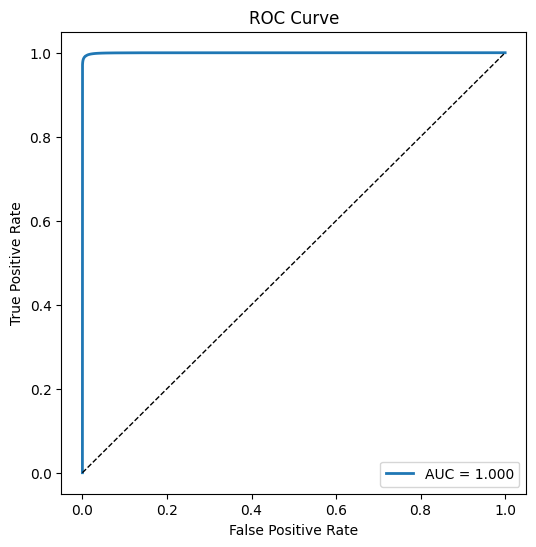

In [8]:
trainer = TumorTrainer(base_dir="drive/MyDrive/data")
_, val_ds = trainer.load_datasets()


device = trainer.device
model = UNetPlusPlus(
    in_ch=1, out_ch=1, n1=32,
    height=val_ds.img_size[0],
    width= val_ds.img_size[1]
).to(device)

model.load_state_dict(
    torch.load("drive/MyDrive/data/best_model.pth", map_location=device)
)

# Evaluate
metrics = evaluate_segmentation(model, val_ds, device=device, batch_size=8)

In [9]:
# ──────────────────────────────────────────────────────────────
#  ClassificationDataset
# ──────────────────────────────────────────────────────────────
class ClassificationDataset(Dataset):

   def __init__(self, df: pd.DataFrame, jpeg_dir: Path, transform: T.Compose):
       self.df        = df.reset_index(drop=True)
       self.jpeg_dir  = Path(jpeg_dir)
       self.transform = transform

       # numeric label 0=benign, 1=malignant once
       self.df["label"] = (
           self.df["pathology"]
           .str.lower().str.strip()
           .eq("malignant")
           .astype(int)
       )

   def __len__(self):
       return len(self.df)

   def __getitem__(self, idx):
       row = self.df.iloc[idx]

       uid, fname = row["cropped image file path"].split("/")[-2:]

       img_fp = self.jpeg_dir / uid / fname

       if not img_fp.exists():
           img_fp = img_fp.with_suffix(".jpg")

       if not img_fp.exists():
           cand = next((self.jpeg_dir / uid).glob("*.jp*"), None)
           if cand is not None:
               img_fp = cand

       if not img_fp.exists():
           raise FileNotFoundError(f"No ROI image found for {uid}")

       img   = Image.open(img_fp).convert("RGB")
       img   = self.transform(img)
       label = torch.tensor(row["label"], dtype=torch.long)

       return img, label

In [11]:
# -----------------------------------------------------------------------------
# 2) Trainer
# -----------------------------------------------------------------------------
class ClassifierTrainer:
   def __init__(self, base_dir="drive/MyDrive/data"):
       self.base_dir = Path(base_dir)
       self.csv_dir  = self.base_dir / "csv"
       self.jpeg_dir = self.base_dir / "jpeg"
       self.device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       print("🔎 Training on device:", self.device)

   def _load_csv(self, filename: str) -> pd.DataFrame:
       df = pd.read_csv(self.csv_dir / filename)
       df = df.dropna(subset=['cropped image file path']).copy()
       def find_img(p):
           parts = p.split('/')
           if len(parts) < 2:
               return None
           uid = parts[-2]
           folder = self.jpeg_dir / uid
           fp = next(folder.glob('*.jp*'), None)
           return str(fp) if (fp and fp.exists()) else None
       df['image_path'] = df['cropped image file path'].map(find_img)
       valid = df[df['image_path'].notnull()].copy()
       print(f"  • {filename}: {len(valid)} samples")
       return valid

   def load_data(self, val_frac=0.1, seed=42):
       trainval = self._load_csv("mass_case_description_train_set.csv")
       _        = self._load_csv("mass_case_description_test_set.csv")
       train_df, val_df = train_test_split(
           trainval,
           test_size=val_frac,
           stratify=trainval['pathology'],
           random_state=seed
       )
       print(f"  → Split train={len(train_df)}, val={len(val_df)}")
       for df in (train_df, val_df):
           df['label'] = (df['pathology'].str.lower().str.strip() == 'malignant').astype(int)
       return train_df, val_df

   def train(self,
             epochs=20,
             batch_size=16,
             lr=3e-5,
             weight_decay=1e-4,
             patience=5,
             val_frac=0.1,
             seed=42,
             num_workers=4):

       # 1) Load & split metadata
       train_df, val_df = self.load_data(val_frac, seed)

       # 2) Transforms
       train_tf = T.Compose([
           T.Resize((256,256)),
           T.RandomResizedCrop(224, scale=(0.8,1.0)),
           T.RandomHorizontalFlip(),
           T.ColorJitter(brightness=0.2, contrast=0.2),
           T.ToTensor(),
           T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
       ])
       val_tf = T.Compose([
           T.Resize((224,224)),
           T.ToTensor(),
           T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
       ])

       # 3) Datasets & Loaders
       train_ds = ClassificationDataset(train_df, self.jpeg_dir, train_tf)
       val_ds   = ClassificationDataset(val_df,   self.jpeg_dir, val_tf)

       train_loader = DataLoader(
           train_ds, batch_size=batch_size, shuffle=True,
           num_workers=num_workers, pin_memory=True
       )
       val_loader = DataLoader(
           val_ds, batch_size=batch_size, shuffle=False,
           num_workers=num_workers, pin_memory=True
       )

       # 4) Model
       model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
       model.fc = nn.Sequential(
           nn.Dropout(0.5),
           nn.Linear(model.fc.in_features, 2)
       )
       model = model.to(self.device)

       # 5) Weighted loss
       counts = train_df['label'].value_counts().to_dict()
       total  = sum(counts.values())
       w0, w1 = total/(2*counts[0]), total/(2*counts[1])
       class_w = torch.tensor([w0, w1], device=self.device)
       criterion = nn.CrossEntropyLoss(weight=class_w)

       optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
       scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
       scaler    = GradScaler()

       best_auc = 0.0
       bad = 0

       # 6) Training loop
       for epoch in range(1, epochs+1):
           # — train —
           model.train()
           running_loss, train_preds, train_labels, train_probs = 0.0, [], [], []
           for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} train"):
               imgs, labels = imgs.to(self.device), labels.to(self.device)
               optimizer.zero_grad()
               with autocast(device_type=self.device.type):
                   logits = model(imgs)
                   loss   = criterion(logits, labels)
               scaler.scale(loss).backward()
               scaler.step(optimizer)
               scaler.update()

               running_loss += loss.item()
               probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
               train_probs.extend(probs)
               train_preds.extend(logits.argmax(dim=1).detach().cpu().numpy())
               train_labels.extend(labels.detach().cpu().numpy())

           train_loss = running_loss / len(train_loader)
           train_acc  = accuracy_score(train_labels, train_preds)
           train_auc  = roc_auc_score(train_labels, train_probs)

           # — validate —
           model.eval()
           running_loss, val_preds, val_labels, val_probs = 0.0, [], [], []
           with torch.no_grad():
               for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} val"):
                   imgs, labels = imgs.to(self.device), labels.to(self.device)
                   with autocast(device_type=self.device.type):
                       logits = model(imgs)
                       loss   = criterion(logits, labels)
                   running_loss += loss.item()
                   probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
                   val_probs.extend(probs)
                   val_preds.extend(logits.argmax(dim=1).detach().cpu().numpy())
                   val_labels.extend(labels.detach().cpu().numpy())

           val_loss = running_loss / len(val_loader)
           val_acc  = accuracy_score(val_labels, val_preds)
           val_auc  = roc_auc_score(val_labels, val_probs)

           print(f"\nEpoch {epoch:02d} | "
                 f"train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, train_auc={train_auc:.3f}  |  "
                 f"val_loss={val_loss:.3f}, val_acc={val_acc:.3f}, val_auc={val_auc:.3f}")

           # early stopping on val_auc
           if val_auc > best_auc:
               best_auc = val_auc
               bad = 0
               torch.save(model.state_dict(), self.base_dir/"best_classifier_v2.pth")
               print("  ✓ Saved new best (val_auc).")
           else:
               bad += 1
               print(f"  ✗ No improvement ({bad}/{patience})")
               if bad >= patience:
                   print("🔶 Early stopping.")
                   break

           scheduler.step()

       return model

In [6]:
# -----------------------------------------------------------------------------
# 3) Script entry-point
# -----------------------------------------------------------------------------
if __name__ == "__main__":
   trainer = ClassifierTrainer(base_dir="drive/MyDrive/data")
   _ = trainer.train(
       epochs=20,
       batch_size=16,
       lr=3e-5,
       weight_decay=1e-4,
       patience=5,
       val_frac=0.1,
       seed=42,
       num_workers=4
   )

🔎 Training on device: cuda
  • mass_case_description_train_set.csv: 1318 samples
  • mass_case_description_test_set.csv: 378 samples
  → Split train=1186, val=132


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Epoch 1/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 val:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 01 | train_loss=0.701, train_acc=0.499, train_auc=0.516  |  val_loss=0.688, val_acc=0.538, val_auc=0.561
  ✓ Saved new best (val_auc).


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 02 | train_loss=0.689, train_acc=0.543, train_auc=0.560  |  val_loss=0.685, val_acc=0.530, val_auc=0.564
  ✓ Saved new best (val_auc).


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 03 | train_loss=0.680, train_acc=0.566, train_auc=0.601  |  val_loss=0.674, val_acc=0.545, val_auc=0.604
  ✓ Saved new best (val_auc).


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0> 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^^^
^
    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^ ^ ^   ^ ^ ^^^^^^^^^^^^^^^^^^
^

Epoch 4/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 04 | train_loss=0.677, train_acc=0.566, train_auc=0.598  |  val_loss=0.673, val_acc=0.568, val_auc=0.606
  ✓ Saved new best (val_auc).


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 05 | train_loss=0.671, train_acc=0.566, train_auc=0.610  |  val_loss=0.679, val_acc=0.515, val_auc=0.582
  ✗ No improvement (1/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 06 | train_loss=0.662, train_acc=0.606, train_auc=0.644  |  val_loss=0.682, val_acc=0.576, val_auc=0.571
  ✗ No improvement (2/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20 val:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 07 | train_loss=0.654, train_acc=0.616, train_auc=0.656  |  val_loss=0.673, val_acc=0.538, val_auc=0.600
  ✗ No improvement (3/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only t

Epoch 8/20 train:   0%|          | 0/75 [00:04<?, ?it/s]

^^^^^^^^^^^^^
^^AssertionError^^: ^^^^can only test a child process^^^^^^
^^^
Exception ignored in: ^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^<function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>^    
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^    ^^^
^self._shutdown_workers() ^
 ^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^    ^ ^if w.is_alive():
 AssertionError^ 
: ^  ^can only test a child process ^ 
 ^  ^ ^
   ^AssertionError^ Exception ignored in: : ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>can only test a child process^^

^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__


Epoch 8/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 08 | train_loss=0.655, train_acc=0.604, train_auc=0.657  |  val_loss=0.679, val_acc=0.553, val_auc=0.619
  ✓ Saved new best (val_auc).


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 09 | train_loss=0.647, train_acc=0.618, train_auc=0.672  |  val_loss=0.684, val_acc=0.614, val_auc=0.599
  ✗ No improvement (1/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 10 | train_loss=0.636, train_acc=0.637, train_auc=0.696  |  val_loss=0.685, val_acc=0.576, val_auc=0.583
  ✗ No improvement (2/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20 val:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795c8e30bec0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 11 | train_loss=0.637, train_acc=0.626, train_auc=0.684  |  val_loss=0.670, val_acc=0.576, val_auc=0.611
  ✗ No improvement (3/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12 | train_loss=0.632, train_acc=0.640, train_auc=0.693  |  val_loss=0.676, val_acc=0.606, val_auc=0.613
  ✗ No improvement (4/5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20 train:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20 val:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 13 | train_loss=0.624, train_acc=0.642, train_auc=0.695  |  val_loss=0.676, val_acc=0.591, val_auc=0.603
  ✗ No improvement (5/5)
🔶 Early stopping.


In [ ]:
from sklearn.metrics import (
   accuracy_score,
   precision_score,
   recall_score,
   roc_auc_score,
   confusion_matrix
)
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader

# 1) Loading & preparing test metadata
test_df = trainer._load_csv("mass_case_description_test_set.csv")
test_df['label'] = (
   test_df['pathology'].str.lower().str.strip() == 'malignant'
).astype(int)
print(f"Test samples: {len(test_df)}")

# 2) Building test DataLoader
test_tf = T.Compose([
   T.Resize((224,224)),
   T.ToTensor(),
   T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_ds = ClassificationDataset(test_df, trainer.jpeg_dir, test_tf)
test_loader = DataLoader(
   test_ds,
   batch_size=16,
   shuffle=False,
   num_workers=4,
   pin_memory=True
)

# 3) Recreating model & load best weights
device = trainer.device
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
   nn.Dropout(0.5),
   nn.Linear(model.fc.in_features, 2)
)
ckpt = trainer.base_dir/"best_classifier_v2.pth"
model.load_state_dict(torch.load(ckpt, map_location=device))
model = model.to(device)
model.eval()

# 4) Inference on test set
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
   for imgs, labels in test_loader:
       imgs = imgs.to(device)
       logits = model(imgs)
       probs  = F.softmax(logits, dim=1)[:,1].cpu().numpy()  # P(malignant)
       preds  = logits.argmax(dim=1).cpu().numpy()

       y_true.extend(labels.numpy())
       y_pred.extend(preds)
       y_prob.extend(probs)

# 5) Computing metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
sens = recall_score(y_true, y_pred)                   # malignant recall
spec = recall_score(y_true, y_pred, pos_label=0)      # benign recall
auc  = roc_auc_score(y_true, y_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"Test Accuracy    : {acc:.4f}")
print(f"Test Precision   : {prec:.4f}")
print(f"Test Sensitivity : {sens:.4f}")
print(f"Test Specificity : {spec:.4f}")
print(f"Test ROC-AUC     : {auc:.4f}")
print(f"Confusion Matrix : TN={tn}, FP={fp}, FN={fn}, TP={tp}")

  • mass_case_description_test_set.csv: 378 samples
Test samples: 378


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy    : 0.6481
Test Precision   : 0.5614
Test Sensitivity : 0.4354
Test Specificity : 0.7835
Test ROC-AUC     : 0.6404
Confusion Matrix : TN=181, FP=50, FN=83, TP=64


In [13]:
# ════════════════════════════════════════════════════════════════════════
# ▶︎ Evaluation + Grad-CAM visualisation
# ════════════════════════════════════════════════════════════════════════
import torch, torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models
import numpy as np, matplotlib.pyplot as plt, cv2
from pathlib import Path
from PIL import Image

# -----------------------------------------------------------
# 1)  Reloading the best classifier weights
# -----------------------------------------------------------
device = trainer.device

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Sequential(
   torch.nn.Dropout(0.5),
   torch.nn.Linear(model.fc.in_features, 2)
)
best_ckpt = trainer.base_dir / "best_classifier_v2.pth"
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model = model.to(device).eval()
print("✓ model loaded:", best_ckpt)

# -----------------------------------------------------------
# 2)  Building test metadata & transform
# -----------------------------------------------------------
test_df = trainer._load_csv("mass_case_description_test_set.csv")

test_tf = T.Compose([
   T.Resize((224, 224)),
   T.ToTensor(),
   T.Normalize([0.485, 0.456, 0.406],
               [0.229, 0.224, 0.225]),
])

test_ds = ClassificationDataset(test_df, trainer.jpeg_dir, test_tf)

# -----------------------------------------------------------
# 3)  Un-normalise helper (for pretty display)
# -----------------------------------------------------------
def unnormalize_tensor(img_t, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
   mean = torch.tensor(mean, device=img_t.device).view(3,1,1)
   std  = torch.tensor(std,  device=img_t.device).view(3,1,1)
   img  = (img_t * std + mean).clamp(0,1).cpu().permute(1,2,0).numpy()
   return (img * 255).astype(np.uint8)

# -----------------------------------------------------------
# 4)  Light-weight Grad-CAM class (layer4 of ResNet-50)
# -----------------------------------------------------------
class GradCAM:
   def __init__(self, model, layer_name="layer4"):
       self.model = model.eval()
       self.layer = dict(self.model.named_modules())[layer_name]   # conv5_x
       self.activations, self.gradients = None, None
       self.layer.register_forward_hook(lambda m,i,o: setattr(self,"activations", o.detach()))
       # for PyTorch ≥1.11
       try:
           self.layer.register_full_backward_hook(lambda m, gi, go: setattr(self,"gradients", go[0].detach()))
       except AttributeError:                                       # fallback for older torch
           self.layer.register_backward_hook(lambda m, gi, go: setattr(self,"gradients", go[0].detach()))

   def __call__(self, img_t, target_class, device):
       x = img_t.unsqueeze(0).to(device)          # add batch-dim
       self.model.zero_grad()
       with torch.amp.autocast(device_type=device.type):
           logit = self.model(x)[0, target_class]
       logit.backward()

       # weights = GAP over spatial dims of gradients
       w = self.gradients.mean(dim=(2,3), keepdim=True)            # 1×C×1×1
       cam = (w * self.activations).sum(dim=1, keepdim=True)       # 1×1×h×w
       cam = torch.relu(cam)

       H,W = img_t.shape[1:]
       cam = F.interpolate(cam, size=(H, W), mode="bilinear", align_corners=False)[0,0]
       cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
       return cam.cpu().numpy()            # H×W [0-1]

# -----------------------------------------------------------
# 5)  Overlay helper
# -----------------------------------------------------------
def show_gradcam(orig, cam, alpha=0.5):
   heat = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
   heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
   overlay = (heat.astype(float)*alpha + orig.astype(float)*(1-alpha)).clip(0,255).astype(np.uint8)

   fig, axs = plt.subplots(1,3, figsize=(12,4))
   axs[0].imshow(orig);        axs[0].set_title("Original"); axs[0].axis("off")
   axs[1].imshow(cam, cmap="jet"); axs[1].set_title("Grad-CAM"); axs[1].axis("off")
   axs[2].imshow(overlay);     axs[2].set_title("Overlay");  axs[2].axis("off")
   plt.tight_layout(); plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


✓ model loaded: drive/MyDrive/data/best_classifier_v2.pth
  • mass_case_description_test_set.csv: 378 samples


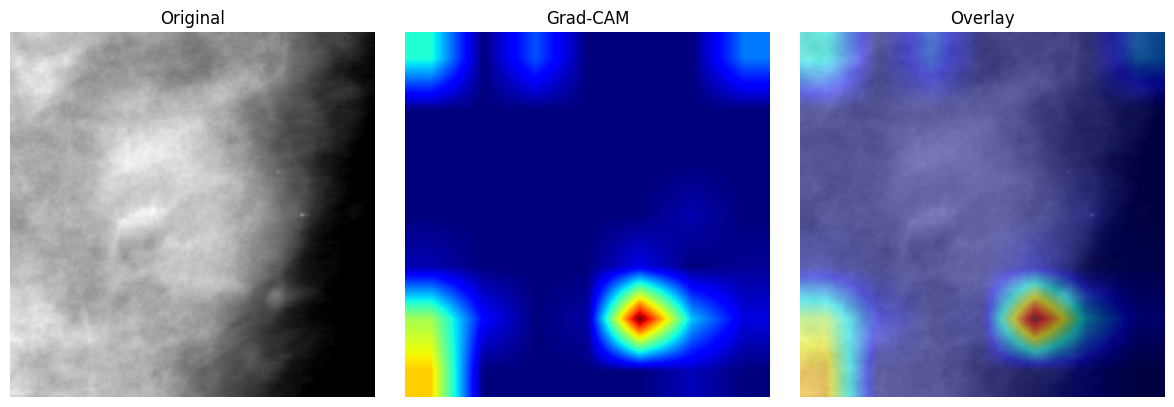

In [15]:
# -----------------------------------------------------------
# 6)  Grad-CAM
# -----------------------------------------------------------
idx   = 24
img_t, label = test_ds[idx]           # tensor, 0=benign / 1=malignant
orig = unnormalize_tensor(img_t)      # uint8 H×W×3

gc  = GradCAM(model, "layer4")
cam = gc(img_t, target_class=label.item(), device=device)

show_gradcam(orig, cam)

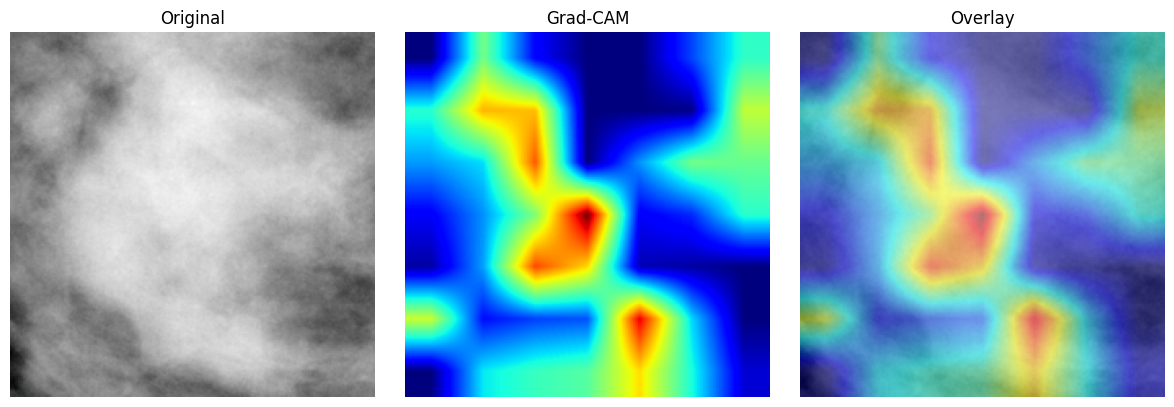

In [49]:
# -----------------------------------------------------------
# 6)  Grad-CAM
# -----------------------------------------------------------
idx   = 55
img_t, label = test_ds[idx]           # tensor, 0=benign / 1=malignant
orig = unnormalize_tensor(img_t)      # uint8 H×W×3

gc  = GradCAM(model, "layer4")
cam = gc(img_t, target_class=label.item(), device=device)

show_gradcam(orig, cam)

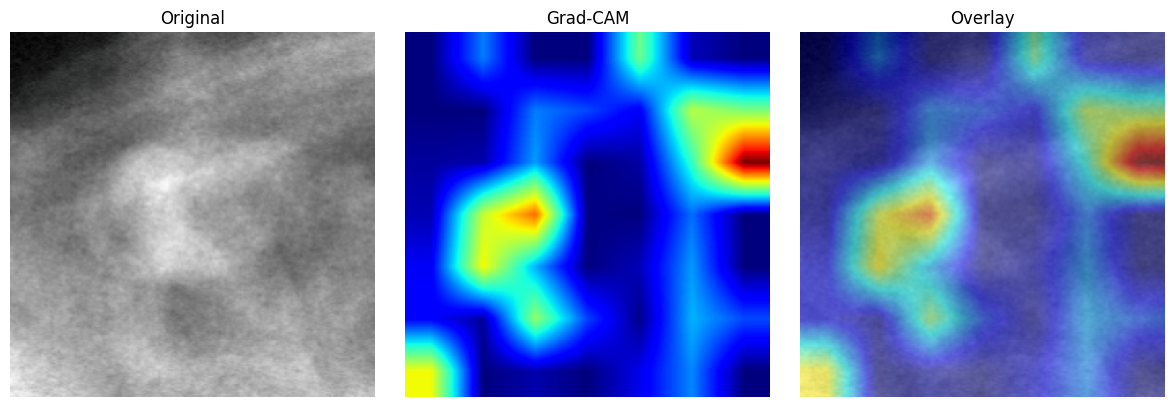

In [53]:
# -----------------------------------------------------------
# 6)  Grad-CAM
# -----------------------------------------------------------
idx   = 59
img_t, label = test_ds[idx]           # tensor, 0=benign / 1=malignant
orig = unnormalize_tensor(img_t)      # uint8 H×W×3

gc  = GradCAM(model, "layer4")
cam = gc(img_t, target_class=label.item(), device=device)

show_gradcam(orig, cam)

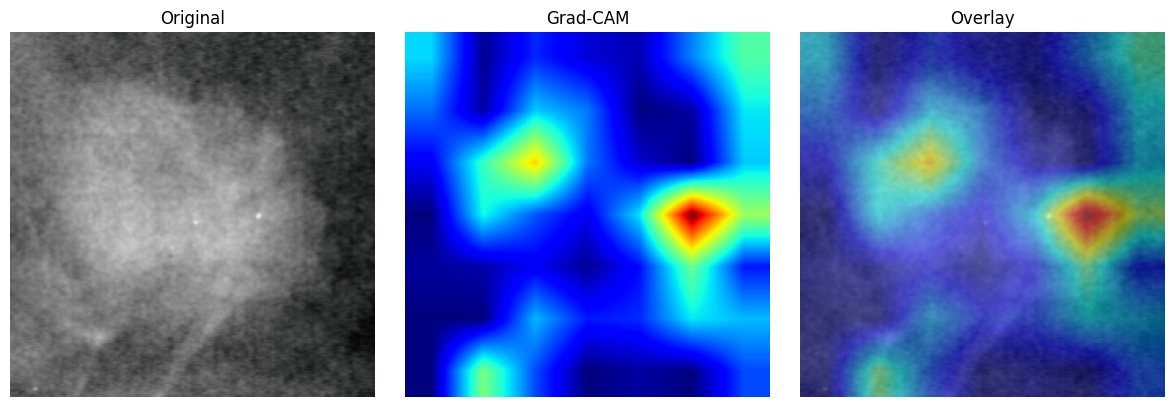

In [56]:
# -----------------------------------------------------------
# 6)  Grad-CAM
# -----------------------------------------------------------
idx   = 62
img_t, label = test_ds[idx]           # tensor, 0=benign / 1=malignant
orig = unnormalize_tensor(img_t)      # uint8 H×W×3

gc  = GradCAM(model, "layer4")
cam = gc(img_t, target_class=label.item(), device=device)

show_gradcam(orig, cam)

In [57]:
# Quantitative Grad-CAM ────────────
import numpy as np
import cv2
from pathlib import Path

def cam_overlap(cam: np.ndarray, mask: np.ndarray, q: float = 0.80):

    thresh   = np.quantile(cam, q)
    cam_bin  = cam >= thresh
    mask_b   = mask.astype(bool)
    inter    = np.logical_and(cam_bin, mask_b).sum()
    dice     = 2 * inter / (cam_bin.sum() + mask_b.sum() + 1e-6)
    union    = cam_bin.sum() + mask_b.sum() - inter
    iou      = inter / (union + 1e-6)
    return dice, iou

dice_scores, iou_scores = [], []
gc = GradCAM(model, layer_name="layer4")

for idx, row in test_df.reset_index(drop=True).iterrows():
    # Computing the CAM
    img_t, label = test_ds[idx]
    cam          = gc(img_t, target_class=label.item(), device=device)

    csv_path = row["cropped image file path"]
    uid      = Path(csv_path).parts[-2]
    folder   = trainer.jpeg_dir / uid
    jpgs     = sorted(folder.glob("*.jp*"))
    if len(jpgs) < 2:
        print(f"⚠️  UID={uid} has only {len(jpgs)} JPEG(s), skipping idx={idx}")
        continue

    # the ROI image is the one already loaded in test_ds
    img_name = Path(row["image_path"]).name
    # mask JPEG is the other one
    mask_fp  = next((p for p in jpgs if p.name != img_name), None)
    if mask_fp is None:
        print(f"⚠️  Couldn't distinguish mask for UID={uid}, skipping idx={idx}")
        continue

    # Loading & binarise the mask JPEG
    raw      = cv2.imread(str(mask_fp), cv2.IMREAD_GRAYSCALE)
    mask_bin = (raw > 127).astype(np.uint8)

    # Resizing to CAM resolution
    H, W     = cam.shape
    mask_rs  = cv2.resize(mask_bin, (W, H), interpolation=cv2.INTER_NEAREST)

    # Computing overlap →
    d, i       = cam_overlap(cam, mask_rs)
    dice_scores.append(d)
    iou_scores.append(i)

# Printing final metrics
print(f"\nGrad-CAM Dice = {np.mean(dice_scores):.3f} ± {np.std(dice_scores):.3f}")
print(f"Grad-CAM IoU  = {np.mean(iou_scores):.3f} ± {np.std(iou_scores):.3f}")

⚠️  UID=1.3.6.1.4.1.9590.100.1.2.423283243012912888204847591923699853302 has only 1 JPEG(s), skipping idx=24
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.273736527812245924738896549683395645939 has only 1 JPEG(s), skipping idx=25
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.141816944311743098818326724042908915517 has only 1 JPEG(s), skipping idx=41
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.144126922913180325224871786602045893599 has only 1 JPEG(s), skipping idx=85
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.373949293413399691210036819474124893691 has only 1 JPEG(s), skipping idx=86
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.67609098512679403432428254042416854686 has only 1 JPEG(s), skipping idx=160
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.271119365811925830039649727131876647231 has only 1 JPEG(s), skipping idx=161
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.116740801513320047136843468024081974184 has only 1 JPEG(s), skipping idx=189
⚠️  UID=1.3.6.1.4.1.9590.100.1.2.250580549713037595829242331282759055654 has only 1 JPEG(s), skipping idx=190
⚠️  UID=1.3.6.1.